# Junior Paper: Bitcoin analysis of returns 

Load and clean data

To do list: 

In [145]:
import pandas as pd 
import numpy as np 
import sys
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import time

from datetime import datetime
from pandas import to_datetime
from statsmodels.regression.quantile_regression import QuantReg
from statsmodels.regression.linear_model import OLS
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse import coo_matrix

In [2]:
df = pd.read_csv('data.csv')
df.head()

,date,market,riskfree,return,vol
0,2014-04-17,0.003714,0.0005,-0.055762,-0.301133
1,2014-04-21,0.001083,0.0006,-0.008854,0.652341
2,2014-04-22,0.005225,0.0006,-0.011670,-0.618118
3,2014-04-23,-0.001937,0.0005,-0.002382,0.518815
4,2014-04-24,0.000839,0.0004,0.016223,-0.084931


In [3]:
date = to_datetime(df['date'])

rm = df['market']
rf = df['riskfree']
ra = df['return']
vol = df['vol']

Create regression variables for CAPM beta estimation, then do quantile regression. 

In [4]:
y = ra - rf
x = rm - rf 
x = sm.add_constant(x)

# Quantile Regression

In [5]:
qr = QuantReg(y,x)
results = qr.fit(q=0.5)
results.summary(xname=['const','x1'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                      y   Pseudo R-squared:            2.992e-05
Model:                       QuantReg   Bandwidth:                     0.01141
Method:                 Least Squares   Sparsity:                      0.05404
Date:                Sun, 22 Apr 2018   No. Observations:                  947
Time:                        23:08:45   Df Residuals:                      945
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.001     -1.963      0.050      -0.004    -3.2e-07
x1             0.0170      0.108      0.157      0.875      -0.196       0.230
==============================================================================
"""

In [32]:
def do_qr(qr, q=0.5):
    res = qr.fit(q=q, max_iter=1000000)
    return [q, res.params['const'], res.params[1], res.conf_int().iloc[1,0], res.conf_int().iloc[1,1]]

In [7]:
quantiles = np.arange(.05, .96, .1)
models = [do_qr(qr, x) for x in quantiles]
models = pd.DataFrame(models, columns=['q', 'b0', 'b1','lb','ub'])

In [8]:
models.head()

,q,b0,b1,lb,ub
0,0.05,-0.056987,2.360304,1.152505,3.568102
1,0.15,-0.025608,1.018933,0.485903,1.551963
2,0.25,-0.014176,0.351648,0.067209,0.636088
3,0.35,-0.008900,0.235938,0.014689,0.457186
4,0.45,-0.004272,0.137548,-0.069186,0.344282


Do OLS for comparison to qreg

In [9]:
y = ra - rf
x = rm - rf 
x = sm.add_constant(x)

In [10]:
ols = OLS(y,x)
ols = ols.fit()
ols_ci = ols.conf_int()[1].tolist()
ols = dict(a = ols.params['const'],
           b = ols.params[1],
           lb = ols_ci[0],
           ub = ols_ci[1])

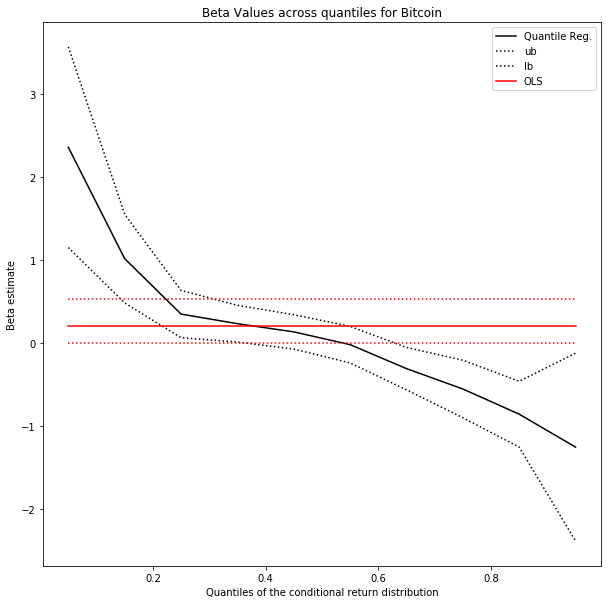

In [12]:
n = models.shape[0]
plt.figure(figsize=(10, 10))
p1 = plt.plot(models.q, models.b1, color='black', label='Quantile Reg.')
p2 = plt.plot(models.q, models.ub, linestyle='dotted', color='black')
p3 = plt.plot(models.q, models.lb, linestyle='dotted', color='black')
p4 = plt.plot(models.q, [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel('Beta estimate')
plt.xlabel('Quantiles of the conditional return distribution')
plt.legend()
plt.title('Beta Values across quantiles for Bitcoin')
plt.savefig('beta_qreg.png')
plt.show()

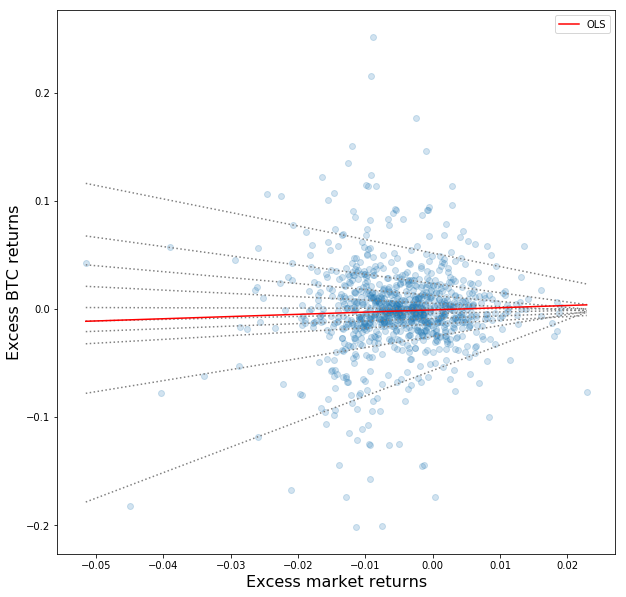

In [13]:
Y = ra - rf
X = rm - rf 

x = np.arange(start=X.min(), stop=X.max(), step=0.0001)
get_y = lambda a, b: a + b * x

fig, ax = plt.subplots(figsize=(10, 10))

for i in range(models.shape[0]):
    y = get_y(models.b0[i], models.b1[i])
    ax.plot(x, y, linestyle='dotted', color='grey')
    
y = get_y(ols['a'], ols['b'])

ax.plot(x, y, color='red', label='OLS')
ax.scatter(X, Y, alpha=.2)
legend = ax.legend()
ax.set_xlabel('Excess market returns', fontsize=16)
ax.set_ylabel('Excess BTC returns', fontsize=16)
plt.savefig('qreg_OLS_scatter.png')
plt.show()

In [14]:
beta = models.b1

In [15]:
beta

0    2.360304
1    1.018933
2    0.351648
3    0.235938
4    0.137548
5   -0.016383
6   -0.305079
7   -0.550257
8   -0.853515
9   -1.250210
Name: b1, dtype: float64

In [16]:
df['month'] = date.map(lambda x: x.month)
df['year'] = date.map(lambda x: x.year)

In [17]:
g = df.groupby(['month', 'year'], sort=False)

In [18]:
monthly_averages = g.aggregate({'return':np.mean})

In [140]:
def qr_monthlybeta(qr, q=0.5):
    res = qr.fit(q=q, max_iter=1000000)
    return [q, res.params[0], res.params[1]]

In [143]:
starttime = time.time()
quantiles = np.arange(.05, .96, .1)
monthly_beta = []
month_year = []
my_df = []
for m_y, mdf in g: 
    month_year.append(m_y)
    y = mdf['return'] - mdf['riskfree']
    x = mdf['market'] - mdf['return']
    x = sm.add_constant(x)
    qr = QuantReg(y,x)
    models = [qr_monthlybeta(qr, x) for x in quantiles]
    models = pd.DataFrame(models, columns=['q', 'b0', 'b1'])
    beta = models.b1
    monthly_beta.append(beta)
"Runtime is: {0}".format(time.time() - starttime)

'Runtime is: 9.90076398849'

In [144]:
monthly_beta = pd.DataFrame(np.asarray(monthly_beta), index=month_year, columns=quantiles)
month_year = pd.DataFrame(month_year)

# 3D plot of monthly beta estimates 

In [155]:
# create coordinates for plotting
coords=coo_matrix(monthly_beta)

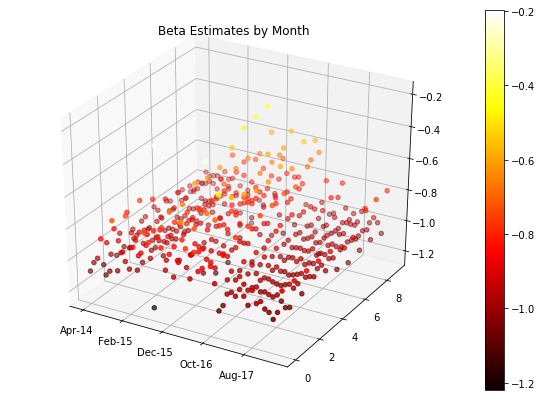

In [216]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.set_xticklabels(labels=['Apr-14','Feb-15','Dec-15', 'Oct-16', 'Aug-17'])
# x is month
# y is quantile 
# Z is the beta 
c = ax.scatter(xs=coords.row, ys=coords.col, zs=coords.data, c=coords.data, cmap='hot')
fig.colorbar(c)
plt.title('Beta Estimates by Month')
plt.savefig('monthly_beta_map')
plt.show()